In [1]:
!pip install lightning
!pip install pigments
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 48.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-m

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

In [47]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
import random
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection

In [48]:
def fix_channels(img):
    if len(img.shape) == 2:
        return ToPILImage()(torch.stack([img for i in (0, 0, 0)]))
    if img.shape[0] == 4:
        return ToPILImage()(img[:3])
    if img.shape[0] == 1:
        return ToPILImage()(torch.stack([img[0] for i in (0, 0, 0)]))
    return ToPILImage()(img)


def xyxy_to_xcycwh(box):

    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):

    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [49]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

In [50]:
train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=0, to=95, unit="%", rounding="pct1_dropremainder"))
val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=95, to=100, unit="%", rounding="pct1_dropremainder"))

In [51]:
cats = train_dataset.features['objects'].feature['category']

In [52]:
def idx_to_text(indexes):
    labels = []
    for i in indexes:
        labels.append(cats.names[i])
    return labels

Plotting random item 1969


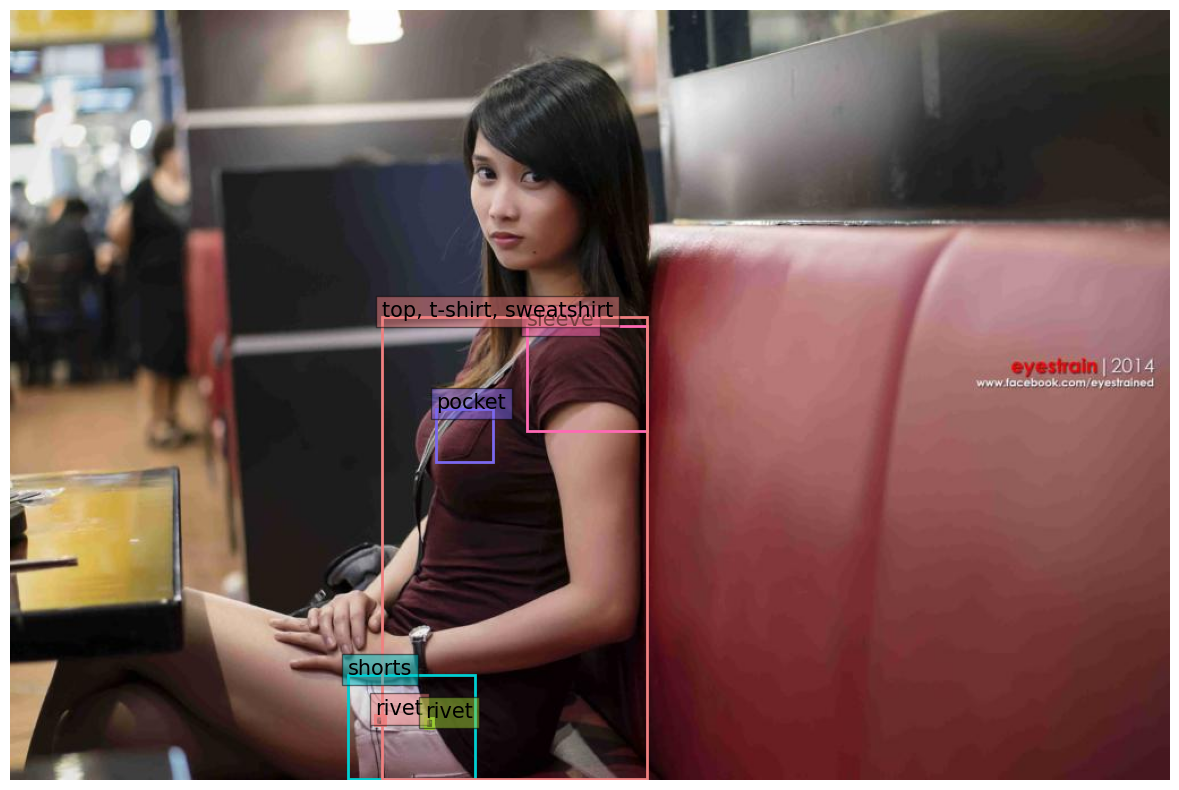

In [53]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

In [54]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [55]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [56]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [57]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [58]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 43320
Number of validation examples: 2280


In [59]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [60]:
item = next(iter(train_dataloader))

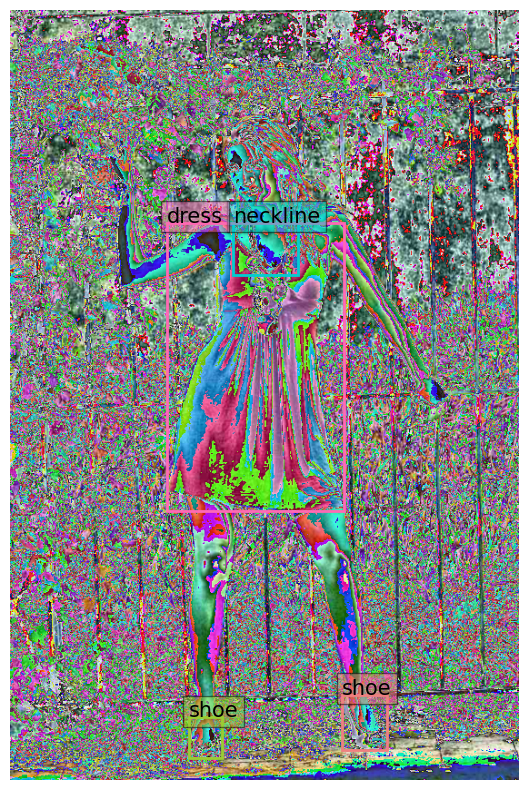

In [61]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

In [62]:
class Yolo(pl.LightningModule):
     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                                  num_labels=cats.num_classes,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [63]:
model = Yolo(lr=2.5e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
trainer = Trainer(max_epochs=1, accelerator="gpu", devices=1)
trainer.fit(model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M | eval
---------------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.670   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                    | Params | Mode
---------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [70]:
import torch

save_path = "model/yolo_model.pth"
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to model/yolo_model.pth
